## Imports

In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import problem
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

## Data Loading and Processing

In [2]:
data = pd.read_parquet(Path("data") / "train.parquet")

In [3]:
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [4]:
df_weather = pd.read_csv("external_data1.csv")
df_weather['date'] = pd.to_datetime(df_weather.date)
df_weather.drop(df_weather.columns[0], axis=1, inplace=True)
df_weather.head()

,date,Temperature (C),wind_dir,wind_speed,Humidity,Visibility,Precipitation,pressure1,sunshine_time,suntime,new_cases,date_only,holidays2
0,2020-09-01 00:00:00,13.9,N,3.7,76.0,20.0,0.0,1020.4,21960.0,48255.0,5104.0,2020-09-01,0
1,2020-09-01 01:00:00,13.6,NNO,1.9,77.0,20.0,0.0,1020.1,21960.0,48255.0,5104.0,2020-09-01,0
2,2020-09-01 02:00:00,13.0,ONO,1.9,79.0,20.0,0.0,1019.9,21960.0,48255.0,5104.0,2020-09-01,0
3,2020-09-01 03:00:00,12.9,NO,1.9,81.0,20.0,0.0,1019.8,21960.0,48255.0,5104.0,2020-09-01,0
4,2020-09-01 04:00:00,12.4,ONO,3.7,83.0,20.0,0.0,1019.5,21960.0,48255.0,5104.0,2020-09-01,0


In [5]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [6]:
date_encoder = FunctionTransformer(_encode_dates, validate=False)
date_encoder.fit_transform(data[["date"]]).head()

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


In [7]:
enc = OneHotEncoder(sparse=False)

enc.fit_transform(_encode_dates(data[["date"]])[["hour"]].head())

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [8]:
X_train_comb = X_train.join(df_weather.set_index("date"), on="date") 
print(X_train_comb.shape)
X_train_comb["y_train"] = y_train.copy()
X_train_comb.dropna(inplace=True)
print(X_train_comb.shape)

y_train = X_train_comb["y_train"]
X_train_comb.drop("y_train", axis=1, inplace=True)

#Do the same operations for X_test
X_test_comb = X_test.join(df_weather.set_index("date"), on="date") 
print(X_test_comb.shape)
X_test_comb["y_test"] = y_test.copy()
X_test_comb.dropna(inplace=True)
print(X_test_comb.shape)

y_test = X_test_comb["y_test"]
X_test_comb.drop("y_test", axis=1, inplace=True)
X_test_comb.shape, y_test.shape
X_train_comb.head()

(455163, 22)
(455163, 23)
(41608, 22)
(41608, 23)


,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,...,wind_speed,Humidity,Visibility,Precipitation,pressure1,sunshine_time,suntime,new_cases,date_only,holidays2
400125,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,...,1.9,77.0,20.0,0.0,1020.1,21960.0,48255.0,5104.0,2020-09-01,0
408305,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,...,1.9,77.0,20.0,0.0,1020.1,21960.0,48255.0,5104.0,2020-09-01,0
87516,100036719-104036719,18 quai de l'Hôtel de Ville NO-SE,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020,...,1.9,77.0,20.0,0.0,1020.1,21960.0,48255.0,5104.0,2020-09-01,0
98518,100036719-103036719,18 quai de l'Hôtel de Ville SE-NO,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020,...,1.9,77.0,20.0,0.0,1020.1,21960.0,48255.0,5104.0,2020-09-01,0
875137,100063175-353277233,20 Avenue de Clichy NO-SE,100063175,20 Avenue de Clichy,2020-09-01 01:00:00,2020-07-22,"48.88529,2.32666",Y2H20073268,48.885290,2.326660,...,1.9,77.0,20.0,0.0,1020.1,21960.0,48255.0,5104.0,2020-09-01,0


## _Ridge Regression_

In [9]:
# Running Basic Ridge Regression to Test the external data

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        #("scaler", scaler, numerical_cols)
    ]
)

regressor = Ridge()

pipe0 = make_pipeline(date_encoder, preprocessor, regressor)
pipe0.fit(X_train_comb, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001FADFFD0EE0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'wind_dir'])])),
                ('ridge', Ridge())])

Train set, RMSE=0.80
Test set, RMSE=0.72
Train set, R^2=0.77
Test set, R^2=0.75


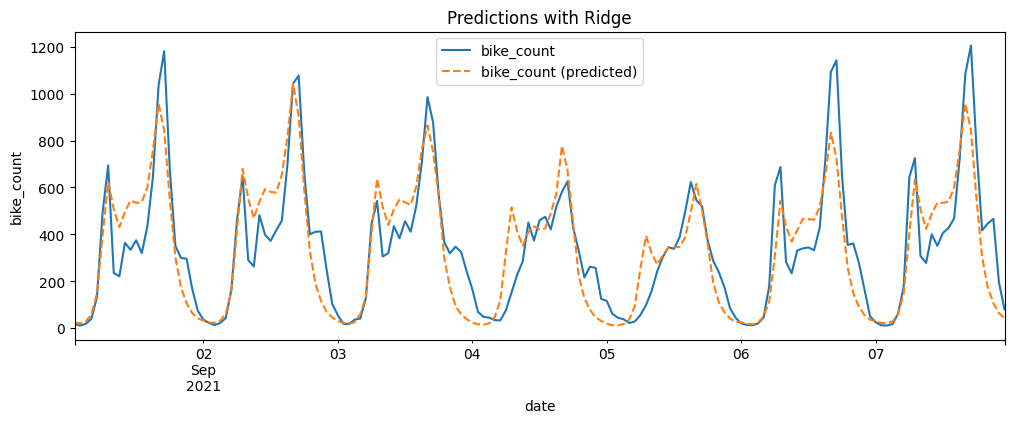

In [10]:
# Declaring a function for our accuracy

def accuracy(pipe):
    mask = (
        (X_test_comb["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
        & (X_test_comb["date"] > pd.to_datetime("2021/09/01"))
        & (X_test_comb["date"] < pd.to_datetime("2021/09/08"))
    )

    df_viz = X_test_comb.loc[mask].copy()
    df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
    df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test_comb[mask])) - 1

    fig, ax = plt.subplots(figsize=(12, 4))

    df_viz.plot(x="date", y="bike_count", ax=ax)
    df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
    ax.set_title("Predictions with Ridge")
    ax.set_ylabel("bike_count") 
    
    print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train_comb), squared=False):.2f}"
    )
    print(
        f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test_comb), squared=False):.2f}"
    )
    

    print(
        f"Train set, R^2={r2_score(y_train, pipe.predict(X_train_comb)):.2f}"
    )
    print(
        f"Test set, R^2={r2_score(y_test, pipe.predict(X_test_comb)):.2f}"
    )
    return None

accuracy(pipe0)


# KNN Regression

In [37]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = ['year', 'month', 'day', 'weekday', 'hour']
#scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = ['site_id', 'latitude', 'longitude', 'Temperature (C)', 'wind_speed',
                'Humidity', 'Visibility', 'Precipitation', 'pressure1', 'sunshine_time',
                'suntime', 'new_cases', 'holidays2']


preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        #("scaler", scaler, numerical_cols)
    ]
)
param_grid = {
    "n_neighbors":[2,4,6,8,10],
    "leaf_size":[2,4,6,8,10]
    }

model = KNeighborsRegressor(weights="distance")

pipe1 = make_pipeline(date_encoder, preprocessor, GridSearchCV(model,
                                                    param_grid,
                                                    n_jobs = 5,
                                                    verbose=10))
pipe1.fit(X_train, y_train)

In [ ]:
accuracy(pipe1)

## Polynomial Features Linear Regression
- Build a grid search for polynomial features.
- Does it only make sense to create polynomial features from numerical columns? Or can we use the entire dataset to create it?

In [ ]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols)
    ]
)

poly_features = PolynomialFeatures()
regressor = Ridge()

pipe = Pipeline([("dates", date_encoder),
                 ("preprocessing", preprocessor),
                 ("poly_features", poly_features), 
                 ("regression", regressor)])

param_grid = {"poly_features__degree":[1, 2, 3]}
search = GridSearchCV(pipe, param_grid, cv=3, verbose=10)

search.fit(X_train_comb, y_train)

In [16]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols)
    ]
)

poly_features = PolynomialFeatures(degree=2)
regressor = Ridge()

pipe = Pipeline([("dates", date_encoder),
                 ("preprocessing", preprocessor),
                 ("poly_features", poly_features), 
                 ("regression", regressor)])


pipe2 = pipe.fit(X_train_comb, y_train)

Pipeline(steps=[('dates',
                 FunctionTransformer(func=<function _encode_dates at 0x000001FADFFD0EE0>)),
                ('preprocessing',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wind_dir'])])),
                ('poly_features', PolynomialFeatures()),
                ('regression', Ridge())])

Train set, RMSE=0.47
Test set, RMSE=0.56
Train set, R^2=0.92
Test set, R^2=0.85


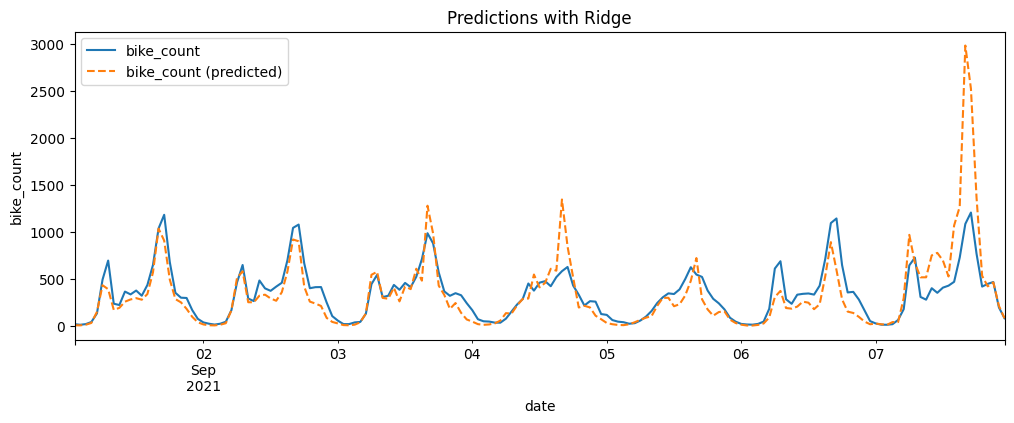

In [17]:
accuracy(pipe2)

## _Support Vector Regression_

In [ ]:
date_encoder = FunctionTransformer(_encode_dates)
imputer = KNNImputer(n_neighbors=3, add_indicator=True)
date_cols = ['year', 'month', 'day', 'weekday', 'hour']

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = ['site_id', 'latitude', 'longitude', 'Temperature (C)', 'wind_speed',
                    'Humidity', 'Visibility', 'pressure1', "Precipitation", "sunshine_time",
                     "suntime", "new_cases"]
     
    
preprocessor = ColumnTransformer(
        [
            ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
            ("cat", categorical_encoder, categorical_cols),
            ("scaler", StandardScaler(), numerical_cols)
        ]
    )

    
regressor = SVR()
    
params = {
        "C": np.arange(1,5),
        "gamma": ["scale", "auto"],
        "epsilon": np.linspace(0.05,0.2, 4)
    }
print(regressor.get_params().keys())
search = RandomizedSearchCV(regressor, 
                               param_distributions=params,
                               scoring='neg_mean_squared_error', 
                               verbose=10,
                               )

pipe3 = make_pipeline(
            date_encoder,
            imputer,
            preprocessor, 
            search)
    
pipe3.fit(X_train_comb, y_train)

In [ ]:
accuracy(pipe3)